### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [3]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here
print(f'{data.isna().sum()['passenger_count']}, {data.isna().sum()['distance_km']}')

145864, 145864


Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [4]:
### Your code is here
most_popular_passenger_count = data.groupby('passenger_count')['passenger_count'].count().sort_values(ascending = False).index[0]
data['passenger_count'] = data['passenger_count'].fillna(most_popular_passenger_count)

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [5]:
### Your code is here
columns_to_group = ['vendor_id','store_and_fwd_flag','traffic_jam',
                    'month_2','month_3','month_4','month_5','month_6']

mean_distance_values = data[~data.distance_km.isna()].groupby(columns_to_group)['distance_km'].mean()
mean_distance_values = mean_distance_values.reset_index()
new_data = pd.merge(
    data,
    mean_distance_values,
    left_on = list(columns_to_group),
    right_on = list(columns_to_group),
    how = 'left'
)
new_data['distance_km_x'] = new_data['distance_km_x'].fillna(new_data.distance_km_y)
new_data = new_data.rename(columns = {'distance_km_x': 'distance_km'})
new_data = new_data.drop(['distance_km_y'], axis = 1)

In [6]:
data

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,1,930.399753,0,1.226296,6.658011,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
id1049543,0,930.399753,0,6.056935,6.486161,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id2304944,1,930.399753,0,7.832952,6.639876,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
data = new_data
my_answer = data.head(20)
my_answer.to_csv('first.csv', sep = ';', index = False)

In [8]:
my_answer = pd.read_csv('first.csv',sep = ';')
my_answer

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
0,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1,1061.355223,0,1.100107,6.095825,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,1053.529749,0,1.327852,5.834811,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,1,930.399753,0,5.722427,7.347300,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,930.399753,0,1.311541,5.545177,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9,1,930.399753,0,5.126939,7.111512,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [9]:
result = pd.read_csv('answer8',sep = ';')
result

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
0,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,930.390000,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,930.390000,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1,1061.355223,0,1.100107,6.095825,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,1053.529749,0,1.327852,5.834811,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,1,930.399753,0,5.722427,7.347300,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,930.399753,0,1.311541,5.545177,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9,1,930.399753,0,5.126939,7.111512,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [10]:
### Убедимся, что пропусков не осталось

### Your code is here
data.isna().sum()

vendor_id             0
passenger_count       0
store_and_fwd_flag    0
distance_km           0
log_trip_duration     0
anomaly               0
traffic_jam           0
day_of_week_1         0
day_of_week_2         0
day_of_week_3         0
day_of_week_4         0
day_of_week_5         0
day_of_week_6         0
hour_1                0
hour_2                0
hour_3                0
hour_4                0
hour_5                0
hour_6                0
hour_7                0
hour_8                0
hour_9                0
hour_10               0
hour_11               0
hour_12               0
hour_13               0
hour_14               0
hour_15               0
hour_16               0
hour_17               0
hour_18               0
hour_19               0
hour_20               0
hour_21               0
hour_22               0
hour_23               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
dtype: int64

In [12]:
data

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
0,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,930.399753,0,1.226296,6.658011,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1458640,0,930.399753,0,6.056935,6.486161,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1458641,1,930.399753,0,7.832952,6.639876,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1458642,0,930.399753,0,1.093786,5.924256,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [14]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here

X = data.drop(['log_trip_duration'], axis = 1)
Y = data['log_trip_duration']

cross_val_errors = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]

    model = LinearRegression()
    model.fit(X_train, Y_train)

    cross_val_errors.append(np.mean((model.predict(X_test) - Y_test)**2))

cross_val_error = np.mean(cross_val_errors)
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

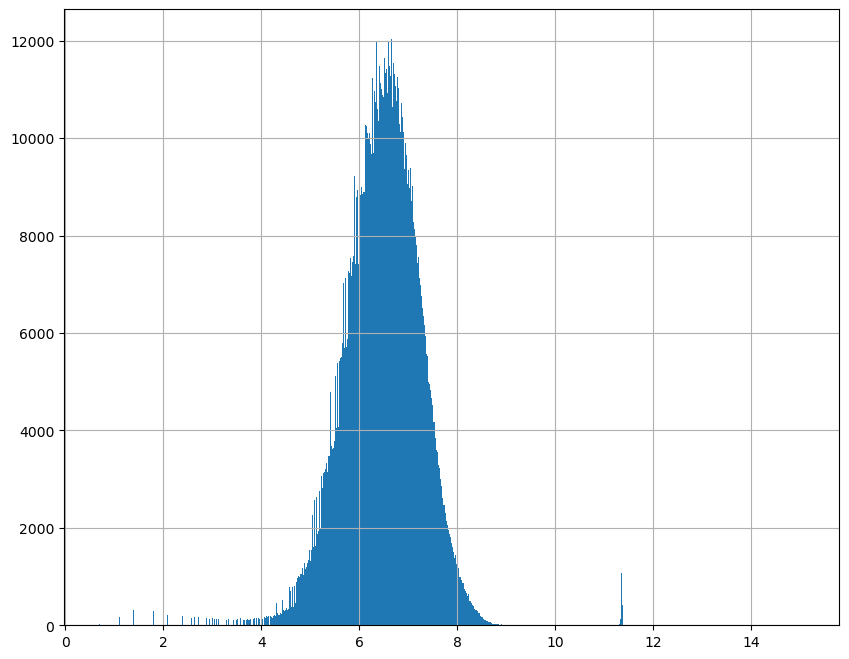

In [16]:
import matplotlib.pyplot as plt

### Your code is here

fig = plt.figure()
fig.set_size_inches(10, 8)

data['log_trip_duration'].hist(bins = 1000)

plt.show()

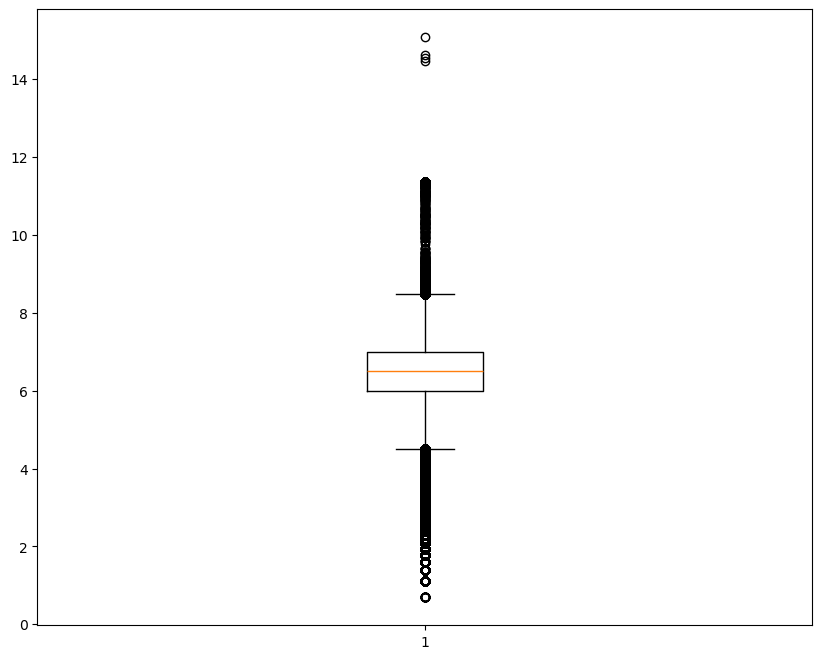

In [17]:
fig = plt.figure()
fig.set_size_inches(10, 8)

plt.boxplot(data['log_trip_duration'].values)

plt.show()

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [30]:
### Your code is here
tentacle_low = data['log_trip_duration'].quantile(0.005)
tentacle_high = data['log_trip_duration'].quantile(0.995)
new_data = data[
    (data['log_trip_duration']>tentacle_low) & (data['log_trip_duration']<tentacle_high)
]


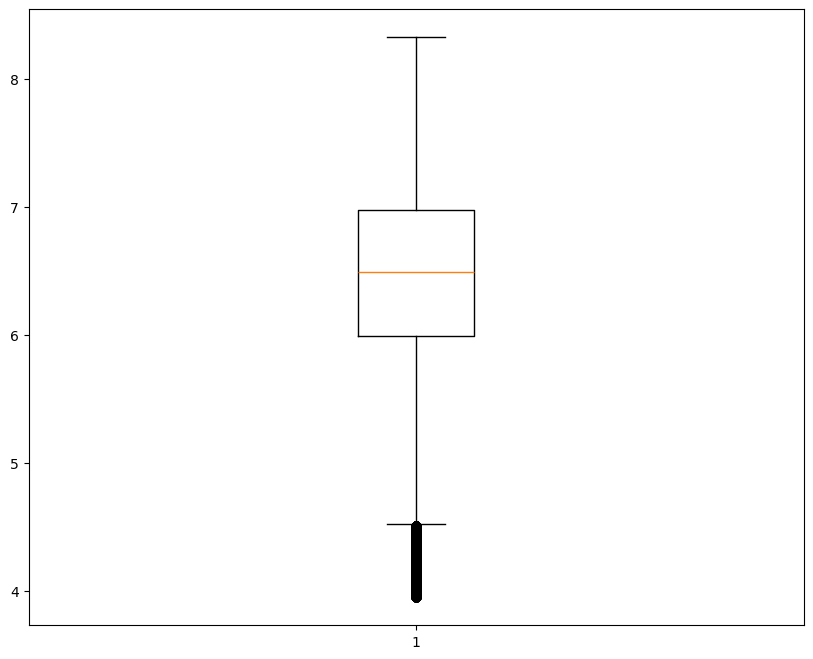

In [31]:
fig = plt.figure()
fig.set_size_inches(10, 8)

plt.boxplot(new_data['log_trip_duration'].values)

plt.show()

Снова замерьте качество на кросс-валидации, используя старый selector

In [32]:
### Your code is here
X = new_data.drop(['log_trip_duration'], axis = 1)
Y = new_data['log_trip_duration']

cross_val_test_errors = []

for train_index, test_index in selector.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]

    model = LinearRegression()
    model.fit(X_train, Y_train)

    cross_val_test_errors.append(np.mean((model.predict(X_test) - Y_test)**2))

cross_val_error = np.mean(cross_val_test_errors)

print(round(cross_val_error,3))

0.35
